<a href="https://colab.research.google.com/github/hsswkwk/turbo-chainsaw/blob/feature-add-object-detection/notebooks/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 物体検出（Object detection）
画像や動画の中から特定の物体を検出し、その位置を特定する技術

<br>

## 物体検出のアーキテクチャ
### 2段階検出器（Two-stage detectors）
まず候補領域を抽出し、次にその候補領域に対して分類と位置の特定を行うという2段階の処理を行う手法。精度は高いが処理速度は遅い。

#### R-CNN
画像から物体が存在する可能性の高い領域（領域候補）を複数抽出し、抽出された各領域候補に対して、CNNを用いて特徴量を抽出する。その後、抽出された特徴量に基づいて、各領域候補がどのクラスに属するかを分類し、物体の位置（バウンディングボックス）を特定する手法。

#### Fast R-CNN
R-CNNを改良した物体検出モデル。Fast R-CNNでは、画像全体に対して一度だけCNNによる特徴量抽出を行う。また、分類と線形回帰によるバウンディングボックスの調整を一つのネットワークで同時に行っている。

#### Faster R-CNN
領域提案ネットワーク (Region Proposal Network: RPN)で候補領域を抽出し、Fast R-CNNによって物体の分類、位置の予測を行う。

#### Mask R-CNN
Faster R-CNNの拡張。物体のマスクを予測するマスクブランチをネットワークに追加し、Rolプーリングの代わりにRolAlignを採用している。

<br>

### 1段階検出器（One-stage detectors）
候補領域の抽出と分類・位置の特定を同時に行う手法。処理速度は速いが精度は低い。

#### YOLO（You Only Look Once）
画像全体を一度だけ見て、物体の検出を行う。以下のステップで処理を行う。
1. 画像をグリッドに分割
2. 各グリッドセルでバウンディングボックスとクラス確率を予測
3. Non-Maximum Suppression (NMS) で重複するバウンディングボックスを削除

#### SSD（Single Shot Multibox Detector）
YOLOとは異なるアプローチの物体検出。以下の特徴を持つ。
1. 複数スケールの特徴マップを使用
2. デフォルトボックス (アンカーボックス)を基準にして、物体の位置とクラスを予測
3. 畳み込み層でバウンディングボックスとクラス確率を予測
4. Non-Maximum Suppression (NMS)で最も確度の高いバウンディングボックスを残す

#### RetinaNet
Focal Lossという損失関数を導入して1段階検出器の精度を向上させた。以下の特徴を持つ。
1. Feature Pyramid Network (FPN)で異なる大きさの物体を検出
2. Focal Lossでクラスの不均衡問題の対処を行う

## 用語メモ
### Backbone
ディープラーニングモデルの主要な特徴抽出部分を指す。特に、物体検出（YOLOv8やRetinaNetなど）のようなタスクでは、画像の特徴を抽出するためのCNN（畳み込みニューラルネットワーク）部分のこと。

In [1]:
# For running inference on the TF-Hub module.
# TensorFlow Hub: 再利用可能な機械学習モデルを公開、発見、利用するためのライブラリとリポジトリ
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
# six.moves.urllib.request は、Python 2と3の互換性を保つためのもの
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"

2.18.0
The following GPU devices are available: 


In [2]:
class ObjectDetectionBase:
  # 画像の表示
  def display_image(self, image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

  # 画像をダウンロード、リサイズして保存し表示する
  def download_and_resize_image(self, url, new_width=256, new_height=256,
                                display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    # 画像のリサイズとトリミング
    # Image.LANCZOS: Lanczosリサンプリングアルゴリズム
    # 他のリサイズアルゴリズムと比較して、一般的に高品質
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
      self.display_image(pil_image)
    return filename

  # 画像の指定した場所にバウンディングボックスを描く
  def draw_bounding_box_on_image(self,
                                 image,
                                 ymin,
                                 xmin,
                                 ymax,
                                 xmax,
                                 color,
                                 font,
                                 thickness=4,
                                 display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
      bbox = font.getbbox(display_str)
      text_width, text_height = bbox[2], bbox[3]
      margin = np.ceil(0.05 * text_height)
      draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                      (left + text_width, text_bottom)],
                     fill=color)
      draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
      text_bottom -= text_height - 2 * margin

  # pathのファイルを画像のテンソルに変換
  def load_img(self, path):
    # pathのファイルをテンソルに変換
    img = tf.io.read_file(path)
    # 画像データをデコードしチャンネル数3のテンソルに変換
    img = tf.image.decode_jpeg(img, channels=3)
    return img

  def run_detector(self, image_path):
    # Implement it in an inherited object.
    pass

  def detect_img(self, image_url):
    start_time = time.time()
    image_path = self.download_and_resize_image(image_url, 640, 480)
    self.run_detector(image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)



In [3]:
# Faster R-CNN
class FasterRCNN(ObjectDetectionBase):
  def __init__(self):
    # モジュールハンドル: TensorFlow Hubで公開されている学習済みモデル（モジュール）を識別するための文字列
    module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
    self.detector = hub.load(module_handle).signatures['default']

  # 画像にバウンディングボックスを描く
  def draw_boxes(self, image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
      font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
      print("Font not found, using default font.")
      font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
      if scores[i] >= min_score:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                       int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        self.draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

  def run_detector(self, path):
    img = self.load_img(path)

    # imgをtf.float32に変換
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    # detectorで物体検出
    result = self.detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # Faster R-CNN
    image_with_boxes = self.draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    self.display_image(image_with_boxes)

In [4]:
# Mask R-CNN
class MaskRCNN(ObjectDetectionBase):
  CLASS_NAMES = [
    {'supercategory': 'person', 'name': 'person'},
    {'supercategory': 'vehicle', 'name': 'bicycle'},
    {'supercategory': 'vehicle', 'name': 'car'},
    {'supercategory': 'vehicle', 'name': 'motorcycle'},
    {'supercategory': 'vehicle', 'name': 'airplane'},
    {'supercategory': 'vehicle', 'name': 'bus'},
    {'supercategory': 'vehicle', 'name': 'train'},
    {'supercategory': 'vehicle', 'name': 'truck'},
    {'supercategory': 'vehicle', 'name': 'boat'},
    {'supercategory': 'outdoor', 'name': 'traffic light'},
    {'supercategory': 'outdoor', 'name': 'fire hydrant'},
    {'supercategory': 'outdoor', 'name': 'street sign'},
    {'supercategory': 'outdoor', 'name': 'stop sign'},
    {'supercategory': 'outdoor', 'name': 'parking meter'},
    {'supercategory': 'outdoor', 'name': 'bench'},
    {'supercategory': 'animal', 'name': 'bird'},
    {'supercategory': 'animal', 'name': 'cat'},
    {'supercategory': 'animal', 'name': 'dog'},
    {'supercategory': 'animal', 'name': 'horse'},
    {'supercategory': 'animal', 'name': 'sheep'},
    {'supercategory': 'animal', 'name': 'cow'},
    {'supercategory': 'animal', 'name': 'elephant'},
    {'supercategory': 'animal', 'name': 'bear'},
    {'supercategory': 'animal', 'name': 'zebra'},
    {'supercategory': 'animal', 'name': 'giraffe'},
    {'supercategory': 'animal', 'name': 'hat'},
    {'supercategory': 'accessory', 'name': 'backpack'},
    {'supercategory': 'accessory', 'name': 'umbrella'},
    {'supercategory': 'accessory', 'name': 'shoe'},
    {'supercategory': 'accessory', 'name': 'eye glasses'},
    {'supercategory': 'accessory', 'name': 'handbag'},
    {'supercategory': 'accessory', 'name': 'tie'},
    {'supercategory': 'accessory', 'name': 'suitcase'},
    {'supercategory': 'sports', 'name': 'frisbee'},
    {'supercategory': 'sports', 'name': 'skis'},
    {'supercategory': 'sports', 'name': 'snowboard'},
    {'supercategory': 'sports', 'name': 'sports ball'},
    {'supercategory': 'sports', 'name': 'kite'},
    {'supercategory': 'sports', 'name': 'baseball bat'},
    {'supercategory': 'sports', 'name': 'baseball glove'},
    {'supercategory': 'sports', 'name': 'skateboard'},
    {'supercategory': 'sports', 'name': 'surfboard'},
    {'supercategory': 'sports', 'name': 'tennis racket'},
    {'supercategory': 'kitchen', 'name': 'bottle'},
    {'supercategory': 'kitchen', 'name': 'plate'},
    {'supercategory': 'kitchen', 'name': 'wine glass'},
    {'supercategory': 'kitchen', 'name': 'cup'},
    {'supercategory': 'kitchen', 'name': 'fork'},
    {'supercategory': 'kitchen', 'name': 'knife'},
    {'supercategory': 'kitchen', 'name': 'spoon'},
    {'supercategory': 'kitchen', 'name': 'bowl'},
    {'supercategory': 'food', 'name': 'banana'},
    {'supercategory': 'food', 'name': 'apple'},
    {'supercategory': 'food', 'name': 'sandwich'},
    {'supercategory': 'food', 'name': 'orange'},
    {'supercategory': 'food', 'name': 'broccoli'},
    {'supercategory': 'food', 'name': 'carrot'},
    {'supercategory': 'food', 'name': 'hot dog'},
    {'supercategory': 'food', 'name': 'pizza'},
    {'supercategory': 'food', 'name': 'donut'},
    {'supercategory': 'food', 'name': 'cake'},
    {'supercategory': 'furniture', 'name': 'chair'},
    {'supercategory': 'furniture', 'name': 'couch'},
    {'supercategory': 'furniture', 'name': 'potted plant'},
    {'supercategory': 'furniture', 'name': 'bed'},
    {'supercategory': 'furniture', 'name': 'mirror'},
    {'supercategory': 'furniture', 'name': 'dining table'},
    {'supercategory': 'furniture', 'name': 'window'},
    {'supercategory': 'furniture', 'name': 'desk'},
    {'supercategory': 'furniture', 'name': 'toilet'},
    {'supercategory': 'furniture', 'name': 'door'},
    {'supercategory': 'electronic', 'name': 'tv'},
    {'supercategory': 'electronic', 'name': 'laptop'},
    {'supercategory': 'electronic', 'name': 'mouse'},
    {'supercategory': 'electronic', 'name': 'remote'},
    {'supercategory': 'electronic', 'name': 'keyboard'},
    {'supercategory': 'electronic', 'name': 'cell phone'},
    {'supercategory': 'appliance', 'name': 'microwave'},
    {'supercategory': 'appliance', 'name': 'oven'},
    {'supercategory': 'appliance', 'name': 'toaster'},
    {'supercategory': 'appliance', 'name': 'sink'},
    {'supercategory': 'appliance', 'name': 'refrigerator'},
    {'supercategory': 'appliance', 'name': 'blender'},
    {'supercategory': 'indoor', 'name': 'book'},
    {'supercategory': 'indoor', 'name': 'clock'},
    {'supercategory': 'indoor', 'name': 'vase'},
    {'supercategory': 'indoor', 'name': 'scissors'},
    {'supercategory': 'indoor', 'name': 'teddy bear'},
    {'supercategory': 'indoor', 'name': 'hair drier'},
    {'supercategory': 'indoor', 'name': 'toothbrush'},
    {'supercategory': 'indoor', 'name': 'hair brush'},
  ]

  def __init__(self):
    # モジュールハンドル: TensorFlow Hubで公開されている学習済みモデル（モジュール）を識別するための文字列
    module_handle = "https://www.kaggle.com/models/tensorflow/mask-rcnn-inception-resnet-v2/TensorFlow2/1024x1024/1"
    self.detector = hub.load(module_handle)


  # 画像にバウンディングボックスを描く
  def draw_boxes(self, image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
      font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
      print("Font not found, using default font.")
      font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
      if scores[i] >= min_score:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        display_str = "{}: {}%".format(self.CLASS_NAMES[int(class_names[i])-1]['name'],
                                       int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        self.draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

  def run_detector(self, path):
    img = self.load_img(path)

    # Mask R-CNN
    converted_img  = img[tf.newaxis, ...]
    start_time = time.time()
    # detectorで物体検出
    result = self.detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = self.draw_boxes(
        img.numpy(), result["detection_boxes"].reshape(-1, 4),
        result["detection_classes"].reshape(-1), result["detection_scores"].reshape(-1))

    self.display_image(image_with_boxes)

Image downloaded to /tmp/tmp1xk9afsd.jpg.
Found 100 objects.
Inference time:  47.20285677909851
Inference time: 47.75848627090454


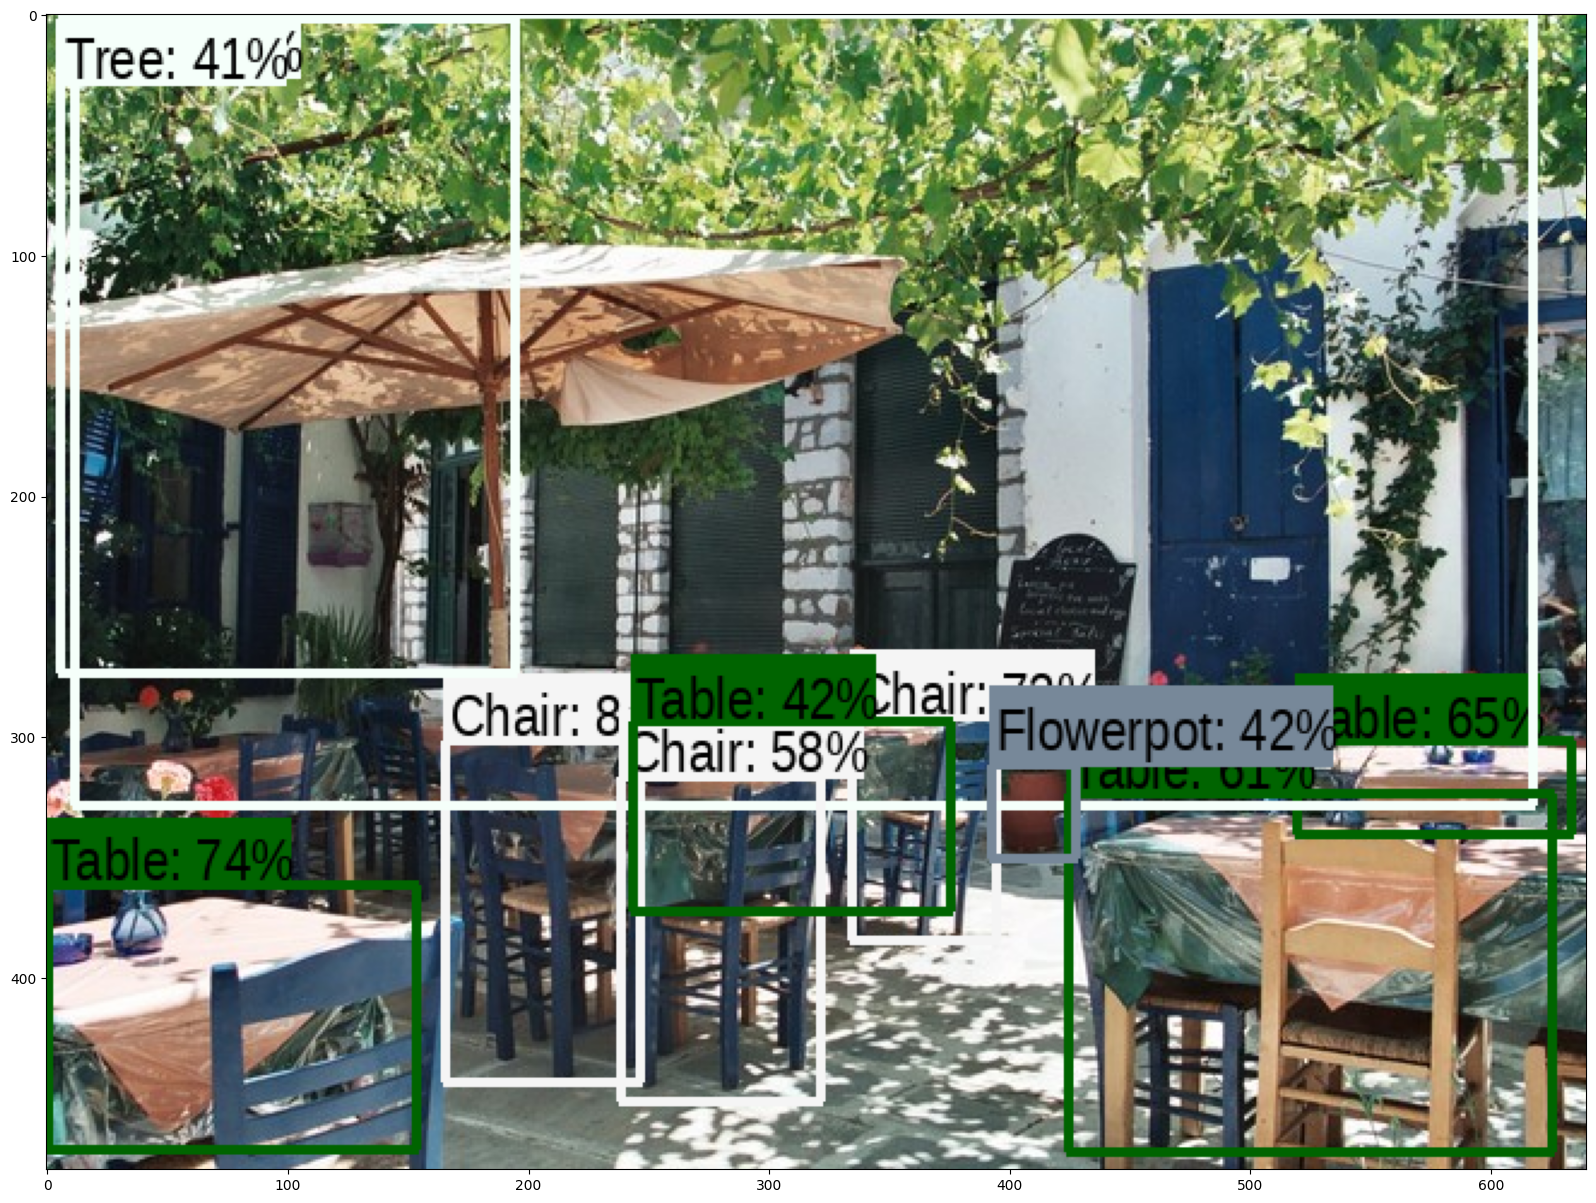

In [5]:
FasterRCNN().detect_img(image_url)

Image downloaded to /tmp/tmp9vj8f7n5.jpg.
Found 1 objects.
Inference time:  44.46947407722473
Inference time: 44.72259068489075


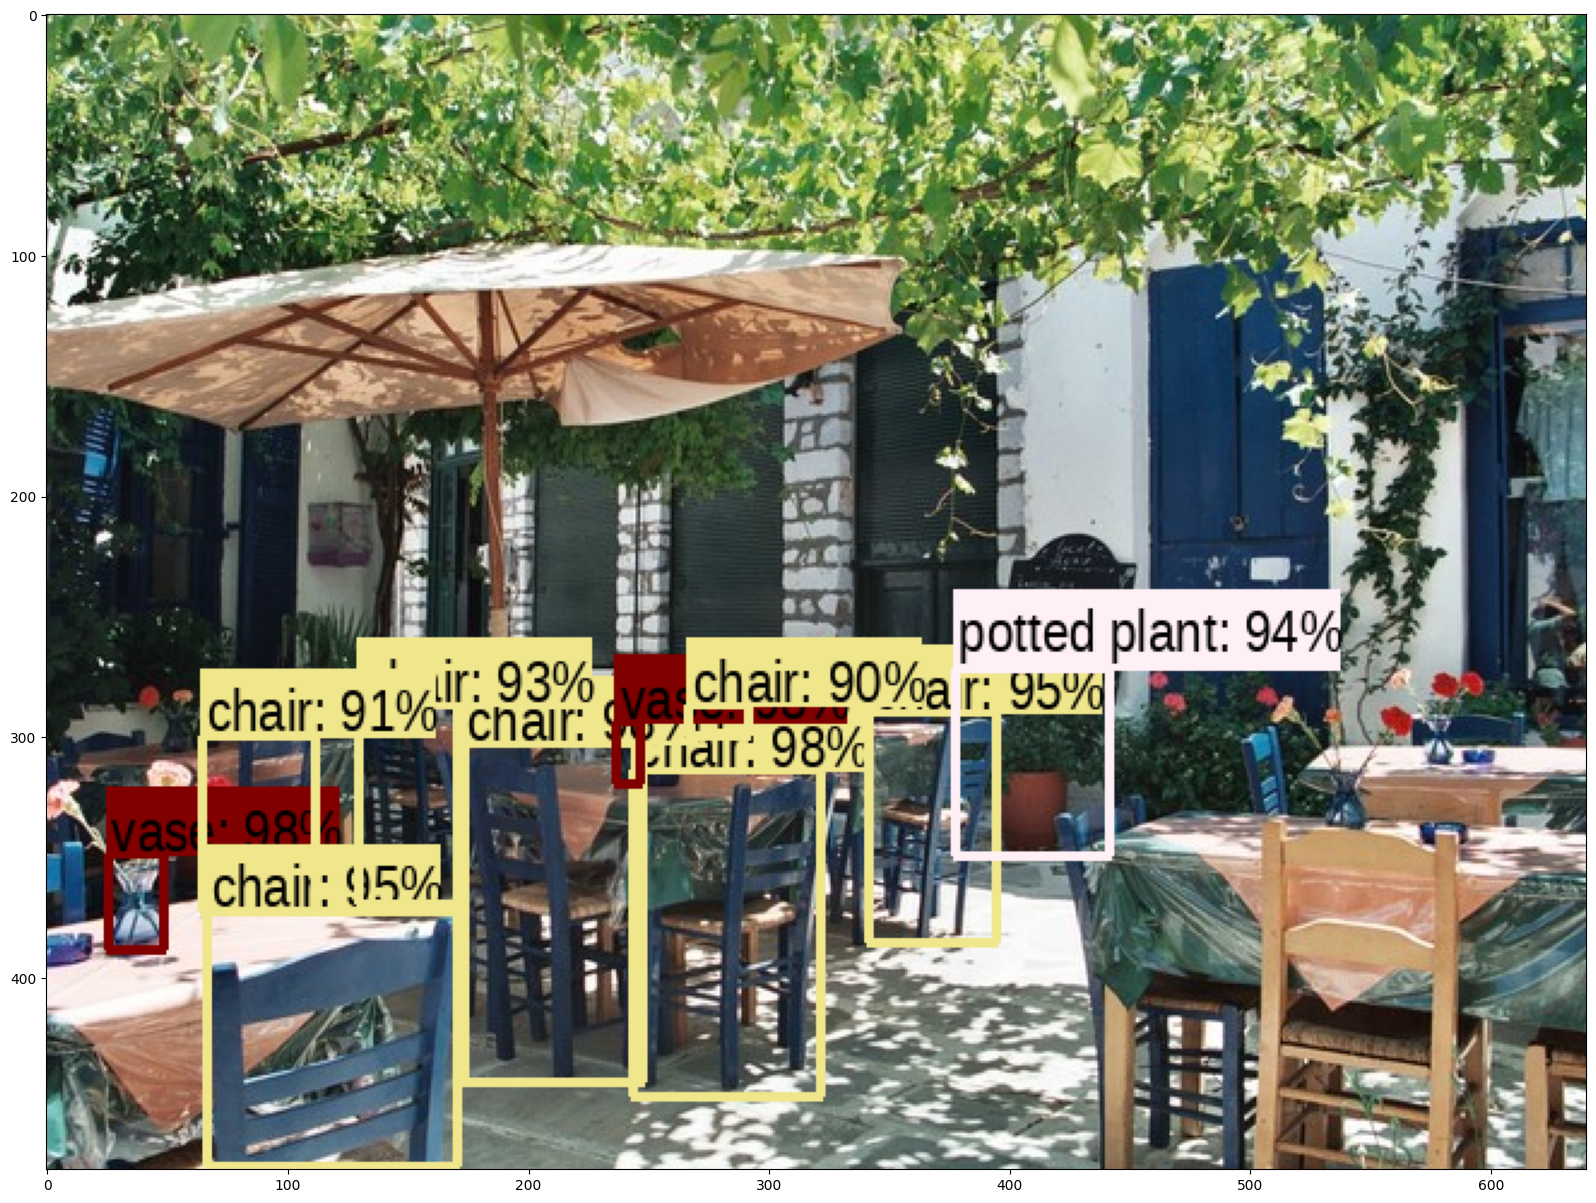

In [6]:
MaskRCNN().detect_img(image_url)